In [28]:
# importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [29]:
df=pd.read_csv('./data/DDH Data with Properties.csv',sep=',')
#Removing the columns where they dont have compound IDs
df=df.drop(df[df['CID']==int(0)].index)
df=df.drop(df[df['pIC50']=='BLINDED'].index)
df['SMILES']=df['SMILES'].astype(str)
df['pIC50']=df['pIC50'].astype(float)
#df.dropna(inplace=True)

In [30]:
#Filled the few null rows which has a compound ID but missing with some data 
#Filled them with the mean of of those columns which were filtered with similar mass of this compound
for i in range(26,len(df.columns)-1):
    df[df.columns[i]].fillna(df[df['ExactMass']>=500][df.columns[i]].mean(),inplace=True)

In [31]:
#dropping the column which are only object 
df = df.drop([ 'CID','MolecularFormula', 'InChI', 'InChIKey', 'IUPACName'], axis=1)

In [32]:
#dropping the column which are only object
df = df.drop(['Charge', 'IsotopeAtomCount', 'DefinedAtomStereoCount', 
              'UndefinedBondStereoCount', 'CovalentUnitCount'], axis=1)

In [6]:
target=df['pIC50']
features=df.drop(['SMILES','pIC50'],axis=1)
target.shape,features.shape

((91,), (91, 28))

In [7]:

min_max_scaler = preprocessing.MinMaxScaler()

features_scaled = min_max_scaler.fit_transform(features)
features_scaled

array([[0.7402892 , 0.78481013, 0.73901645, ..., 0.5       , 0.68627451,
        1.        ],
       [0.84406011, 0.69620253, 0.84429379, ..., 0.75      , 0.78431373,
        1.        ],
       [0.86986107, 0.87341772, 0.86981111, ..., 0.5       , 0.78431373,
        1.        ],
       ...,
       [0.66061809, 0.67088608, 0.66216949, ..., 0.        , 0.31372549,
        1.        ],
       [0.88006805, 0.65822785, 0.88094554, ..., 0.25      , 0.50980392,
        1.        ],
       [0.75985257, 0.50632911, 0.76176148, ..., 0.25      , 0.52941176,
        1.        ]])

In [33]:
features_scaled.shape

(91, 28)

In [8]:
X_train,X_test,y_train,y_test=train_test_split(features_scaled, target, test_size=0.2, random_state=2212)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72, 28), (19, 28), (72,), (19,))

In [19]:
num_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean'))])

In [20]:
def test_model(models, X_train, y_train): 
    model = Pipeline(steps=[('preprocessing', num_pipeline),('models', models)])
    model.fit(X_train, y_train)
    return model

In [21]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
models = [RandomForestRegressor(), 
          AdaBoostRegressor(), 
          GradientBoostingRegressor(), 
          BaggingRegressor(), 
          SVR(),
          DecisionTreeRegressor(), 
          ExtraTreeRegressor(),
          LinearRegression(), 
          SGDRegressor(), 
          KNeighborsRegressor()]

In [23]:
model_names = []
mses = []
maes = []

for model in models:
    name = type(model).__name__
    model_names.append(name)
    model = test_model(model, X_train, y_train)
    pred = model.predict(X_test)
    mses.append(mean_squared_error(y_test, pred))
    maes.append(mean_absolute_error(y_test, pred))

In [25]:
results_dict = {'Model': names, 'MSE': mses, 'MAE': maes}
pd.DataFrame(results_dict).sort_values(by='MSE', ascending=1)

,Model,MSE,MAE
4,SVR,0.188553,0.365123
0,RandomForestRegressor,0.213361,0.373585
3,BaggingRegressor,0.234109,0.386509
9,KNeighborsRegressor,0.245489,0.406286
1,AdaBoostRegressor,0.262730,0.419973
2,GradientBoostingRegressor,0.266303,0.382030
8,SGDRegressor,0.346101,0.529689
7,LinearRegression,0.401804,0.445180
6,ExtraTreeRegressor,0.626515,0.567311
5,DecisionTreeRegressor,0.673207,0.715355


<Axes: ylabel='pIC50'>

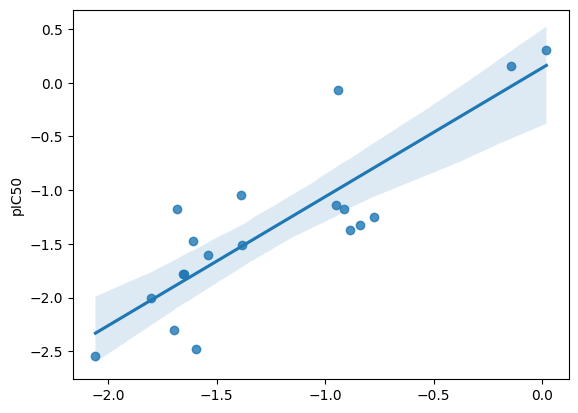

In [26]:
model = test_model(SVR(), X_train, y_train)
pred = model.predict(X_test)

sns.regplot(x = pred, y = y_test)

In [18]:
from sklearn.svm import SVR
svr = SVR()

svr.fit(X_train, y_train)
print(svr.score(X_train, y_train))
print(svr.score(X_test, y_test))

svr_pred = svr.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)
print(svr_mse)

0.6222531621215464
0.6838953739793334
0.18855318713696326


<Axes: ylabel='pIC50'>

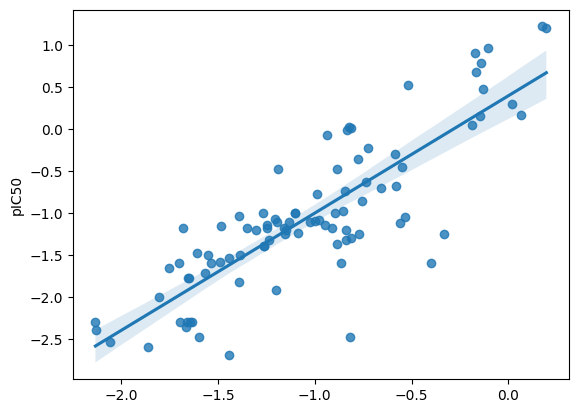

In [19]:
pred = model.predict(features_scaled)

sns.regplot(x = pred, y = target)

In [21]:
from rdkit import Chem 

# transforming SMILEs object data to rdkit object
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


In [22]:
from rdkit.Chem import Draw

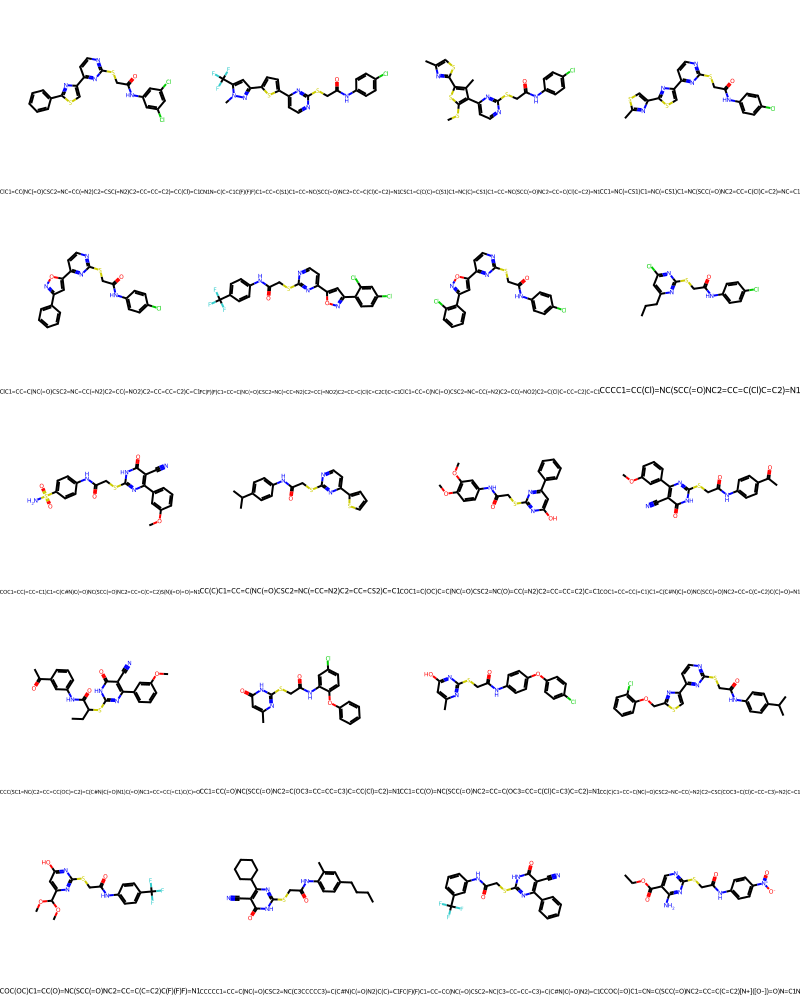

In [23]:
#MolsToGridImage visulaizes the molecular structure of the SMILES
Draw.MolsToGridImage(df['mol'].iloc[:20], molsPerRow=4, useSVG=True, 
                     legends=list(df['SMILES'][:20].values))
